In [1]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parent))

### First, deriving the scheme

First I want to rederive the scheme for SHE that will be used for fine and coarse grids.

We have:
$$
\frac{\partial u}{\partial t} - \frac{\partial^2 u}{\partial t^2} = \xi (x,t)\\
\text{Integrating both sides over a square gives: }\\
\quad \int_{t_n}^{t_{n+1}} \int_{x_{j-\frac{\Delta x}{2}}}^{x_{j+\frac{\Delta x}{2}}}\left(\frac{\partial u}{\partial t} - \frac{\partial^2 u}{\partial t^2}\right) dxdy = \int_{t_n}^{t_{n+1}} \int_{x_{j-\frac{\Delta x}{2}}}^{x_{j+\frac{\Delta x}{2}}}\xi(x,t) dx dy \\
\text{LHS - First term} \\
\int_{t_n}^{t_{n+1}} \int_{x_{j-\frac{\Delta x}{2}}}^{x_{j+\frac{\Delta x}{2}}}\frac{\partial u}{\partial t} dx dy = \int_{x_{j-\frac{\Delta x}{2}}}^{x_{j+\frac{\Delta x}{2}}}(u(x, t_n) - u(x, t_{n+1})) dx \approx \Delta x \left( u_j^{n+1} - u_j^{n} \right)\\
\text{LHS - Second term} \\
\int_{t_n}^{t_{n+1}} \int_{x_{j-\frac{\Delta x}{2}}}^{x_{j+\frac{\Delta x}{2}}}u_{xx}(t,x)dxdt = \int_{t_n}^{t_{n+1}} \left[u_x(t, x_j + \frac{\Delta x}{2}) - u_x(t, x_j - \frac{\Delta x}{2})\right] dt \approx \Delta t \left( \frac{u_{j+1}^{n} - 2 u_j^n + u_{j-1}^n}{\Delta x} \right) \\
\text{RHS} \\
\int_{t_n}^{t_{n+1}} \int_{x_{j-\frac{\Delta x}{2}}}^{x_{j+\frac{\Delta x}{2}}} \xi(x,t) dx dy = \sqrt{\Delta x \Delta t} Z_i^n \quad \text{where } Z_i^n \sim \mathcal{N}(0, 1)\\
\text{Putting this together and rearranging yields: }\\
u_j^{n+1} = u_j^n + \frac{\Delta t}{(\Delta x)^2} \left(u_{j+1}^n - 2 u_j^n + u_{j-1}^n \right) + \sqrt{\frac{\Delta t}{\Delta x}} Z_i^n
$$
This is my finite difference scheme.
### Second, how do we couple noises together at different mesh levels?

So for this, it's crucial that noises from fine squares are used to construct the squares making up steps at the coarse level. I'll do some work for this below in a notebook cell. The other thing is ensuring these scale to give the desired variance, which leads me to the next point...

### For the Stochastic Heat Equation

Bit of maths behind this one. First, we have that $\Delta x_c = 2 \Delta x_f$ and $\Delta t_c = 4 \Delta t_f$.

$$
\text{Target coarse variance: } \mathbb{V}\left[dWc \right] = \frac{\Delta t_c}{\Delta x_c} =   \frac{4 \Delta t_f}{2 \Delta x_f} = 2 \frac{\Delta t_f}{\Delta x_f} \\
\text{Currently I'm summing 8 squares though...Let } \tilde{dW_c} \text{ be what I currently calculate by simply summing the neighbouring fine squares} \\
\mathbb{V} \left[\tilde{dW_c}\right] = \mathbb{V} \left[\sum_{i=1}^8 dW_f^{(i)} \right] = 8 \mathbb{V}\left[dW_f\right] = 8 \frac{\Delta t_f}{\Delta x_f} = 4 \mathbb{V}\left[dW_c\right]\\
\text{This is 4 times the variance I want. To resolve: } dW_c = \alpha \tilde{dW_c} \\
\mathbb{V}\left[ dW_c \right] = \alpha^2 \mathbb{V}\left[\tilde{dW_c}\right] \\
2 \frac{\Delta t_f}{\Delta x_f} = \alpha^2 8 \frac{\Delta t_f}{\Delta x_f} \\
\alpha^2 = \frac{1}{4} \quad \alpha = \frac{1}{2}
$$


In [21]:
## Let's explore noise resolution formulas then. First, the one suggested by Prof. Giles
u_fine = np.array([0, 1, 2, 3, 4, 5, 6, 7, 0])
nf = len(u_fine) - 1
nc = nf // 2
n_coarse = np.zeros(len(u_fine) // 2 + 1)
u_coarse[1:-1] = (
    0.5 * u_fine[1:-3:2] +
    u_fine[2:-2:2] +
    0.5 * u_fine[3:-1:2]
)
print(u_coarse) # all correct

[ 0.  4.  8. 12.  0.]


In [24]:
# And the previous method I was doing - what does that give me
u_fine[1:-2].reshape(nc - 1, 2).sum(axis=1)

array([ 3,  7, 11])

In [28]:
# And now for an array where rows are points and columns are samples
u_fine = np.array([[0, 1, 2, 3, 4, 5, 6, 7, 0],
                   [0, 1, 2, 3, 4, 5, 6, 7, 0]]).T
u_coarse = np.zeros((nc + 1, 2))
u_coarse[1:-1, :] = (
    0.5 * u_fine[1:-3:2] + 
    u_fine[2:-2:2] + 
    0.5 * u_fine[3:-1:2]
)
u_coarse

array([[ 0.,  0.],
       [ 4.,  4.],
       [ 8.,  8.],
       [12., 12.],
       [ 0.,  0.]])

In [35]:
# and now if we just have the internal points
u_fine = np.array([[1, 2, 3, 4, 5, 6, 7],
                   [1, 2, 3, 4, 5, 6, 7]]).T
# u_coarse = np.zeros(((u_fine.shape[0] - 1) // 2, 2))
u_coarse = (0.5 * u_fine[:-2:2, :] + 
            u_fine[1:-1:2, :] + 
            0.5 * u_fine[2::2, :])
u_coarse


array([[ 4.,  4.],
       [ 8.,  8.],
       [12., 12.]])

In [36]:
def default_noise_coupling(dWf):
    
    coupled_noises = (0.5 * dWf[:-2:2, :] +
                      dWf[1:-1:2, :] + 
                      0.5 * dWf[2::2, :])
    coupled_noises *= 0.5
    return coupled_noises
u_fine = np.array([[1, 2, 3, 4, 5, 6, 7],
                   [1, 2, 3, 4, 5, 6, 7]]).T
default_noise_coupling(u_fine) # all working

array([[2., 2.],
       [4., 4.],
       [6., 6.]])

In [40]:
def suspect_noise_coupling(dWf):
    num_rows = int(dWf.shape[0] / 2 - 0.5) # nf - 1 internal points for fine. Corresponds to (nf + 1) / 2 - 1 coarse internals
    dWc =  dWf[:-1, :].reshape(num_rows, 2, dWf.shape[1]).sum(axis=1) # sum of 2 fine adjacent increments, ignore final point
    return dWc

u_fine = np.array([[1, 2, 3, 4, 5, 6, 7],
                   [1, 2, 3, 4, 5, 6, 7]]).T
suspect_noise_coupling(u_fine)


array([[ 3,  3],
       [ 7,  7],
       [11, 11]])

l = 0
l = 1
l = 2
l = 3
l = 4
l = 5
l = 6
Estimates of key MLMC Theorem parameters based on linear regression: 
alpha = 0.584341 (exponent for MLMC weak convergence)
beta = 2.155667 (exponent for MLMC variance)
gamma = 2.906758 (exponent for MLMC cost
eps = 0.005
Adding new level 3 with remaining error 0.074703 > eps/sqrt(2) = 0.003536
New level 3 added, with 83 samples and variance 0.000411
Adding new level 4 with remaining error 0.011539 > eps/sqrt(2) = 0.003536
New level 4 added, with 22 samples and variance 0.000092
Adding new level 5 with remaining error 0.008713 > eps/sqrt(2) = 0.003536
New level 5 added, with 4 samples and variance 0.000010
Adding new level 6 with remaining error 0.005811 > eps/sqrt(2) = 0.003536
New level 6 added, with 1 samples and variance 0.000003
Adding new level 7 with remaining error 0.004736 > eps/sqrt(2) = 0.003536
New level 7 added, with 1 samples and variance 0.000000
eps = 0.01
Adding new level 3 with remaining error 0.074192 > eps/sqrt(2) = 0.007071

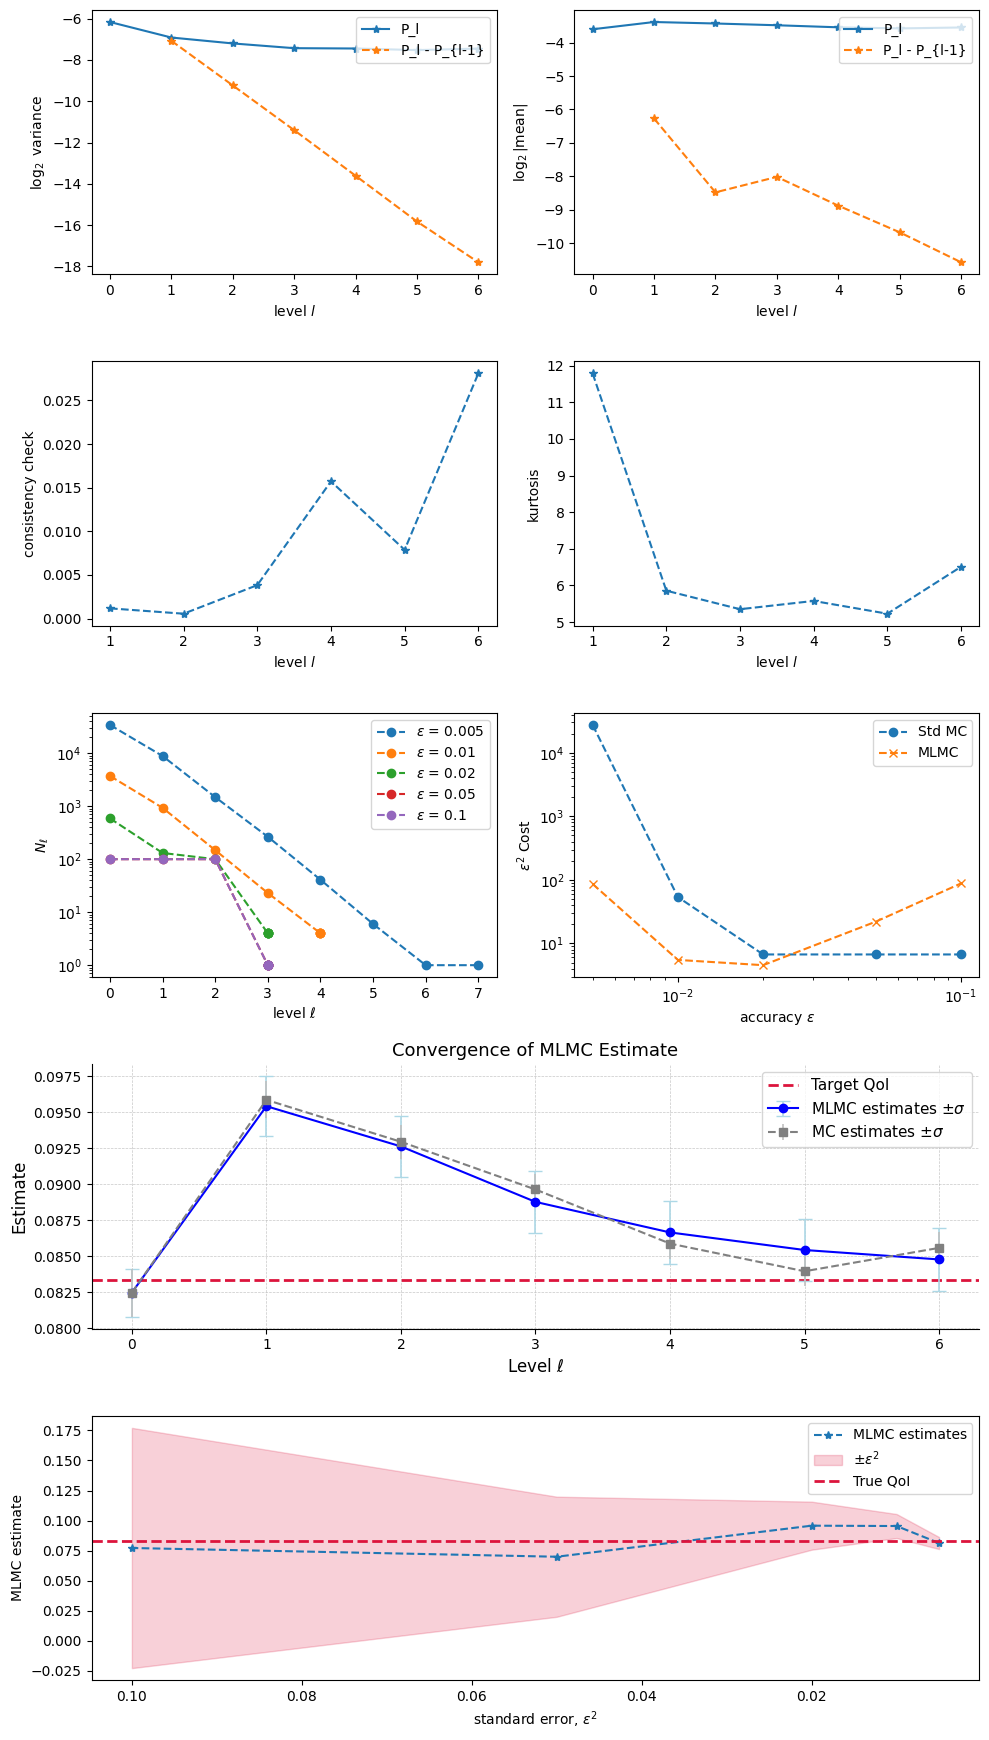

(array([ 0.08248698,  0.01294947, -0.00279497, -0.00385375, -0.00212169,
        -0.00122062, -0.0006554 ]),
 array([0.08248698, 0.09587652, 0.09296357, 0.08965033, 0.08589142,
        0.08396785, 0.08559169]),
 array([1.39739216e-02, 7.43913279e-03, 1.66395053e-03, 3.70366885e-04,
        8.02460262e-05, 1.72562323e-05, 4.38915917e-06]),
 array([0.01397392, 0.00829901, 0.00680781, 0.00580573, 0.00574203,
        0.00544267, 0.00572197]))

In [12]:
from mlmc.stoch_heat_eqn_qoi import stoch_heat_eqn_qoi
def suspect_noise_coupling(dWf):
    num_rows = int(dWf.shape[0] / 2 - 0.5) # nf - 1 internal points for fine. Corresponds to (nf + 1) / 2 - 1 coarse internals
    dWc =  dWf[:-1, :].reshape(num_rows, 2, dWf.shape[1]).sum(axis=1) * 0.5 # sum of 2 fine adjacent increments, ignore final point. Multiply each increment by 0.5.
    return dWc
stoch_heat_eqn_qoi(noise_coupling=suspect_noise_coupling)

#### New noise coupling: take adjacent squares plus the one ahead

The idea behind this coupling scheme is to take half of the adjacent squares to each fine timestep, alongside the middle one, and sum them together as the fine grid
advances. Using the following notation

Coarse-level noise increment: $ \xi^{(c)}_j$ at spatial index $j$\
We use three adjacent fine-level increments $\xi^{(f)}_{2j-1}, \xi^{(f)}_{2j}, \xi^{(f)}_{2j+1}$.

The combining scheme for each timestep is:

$$
\tilde{\xi}^{(c)}_j = \frac{1}{\sqrt{3}} \left( \frac{1}{2} \xi^{(f)}_{2j-1} + \xi^{(f)}_{2j} + \frac{1}{2} \xi^{(f)}_{2j+1} \right)
$$

This corresponds to the NumPy-style computation:

```python
coupled_noises = (
    0.5 * dWf[:-2:2, :] +
    dWf[1:-1:2, :] +
    0.5 * dWf[2::2, :]
)
coupled_noises *= 1 / np.sqrt(3)
```

---

### Why the $\sqrt{\frac{1}{3}}$?

Assume each fine noise increment $\xi^{(f)}_k \sim \mathcal{N}(0, \sigma^2)$, independent.

Then the variance of each amalgamated increment is:

$$
\mathbb{V}[\tilde{\xi}^{(c)}_j]
= \left( \frac{1}{3} \right)^2 \left( \frac{1}{4} + 1 + \frac{1}{4} \right)\sigma_f^2
= \frac{1}{2} \sigma_f^2\\
\text{We sum 4 timesteps for each coarse grid, so we obtain: } \xi_c = 4 \left( \frac{1}{2} \sigma_f^2\right) = 2 \sigma_f^2 = \sigma_c^2
$$


l = 0
l = 1
l = 2
l = 3
l = 4
l = 5
l = 6
Estimates of key MLMC Theorem parameters based on linear regression: 
alpha = -0.224809 (exponent for MLMC weak convergence)
beta = 0.242575 (exponent for MLMC variance)
gamma = 2.969167 (exponent for MLMC cost
eps = 0.005
Estimated alpha: 0.500000
Estimated alpha: 0.500000
Estimated alpha: 0.500000
Adding new level 3 with remaining error 0.102078 > eps/sqrt(2) = 0.003536
New level 3 added, with 196 samples and variance 0.001409
Estimated alpha: 0.500000
Adding new level 4 with remaining error 0.048317 > eps/sqrt(2) = 0.003536
New level 4 added, with 89 samples and variance 0.000621
Estimated alpha: 0.500000
Estimated alpha: 0.500000
Adding new level 5 with remaining error 0.053941 > eps/sqrt(2) = 0.003536
New level 5 added, with 69 samples and variance 0.000508
Estimated alpha: 0.500000
Estimated alpha: 0.500000
Adding new level 6 with remaining error 0.060133 > eps/sqrt(2) = 0.003536
New level 6 added, with 57 samples and variance 0.000433
Es

KeyboardInterrupt: 

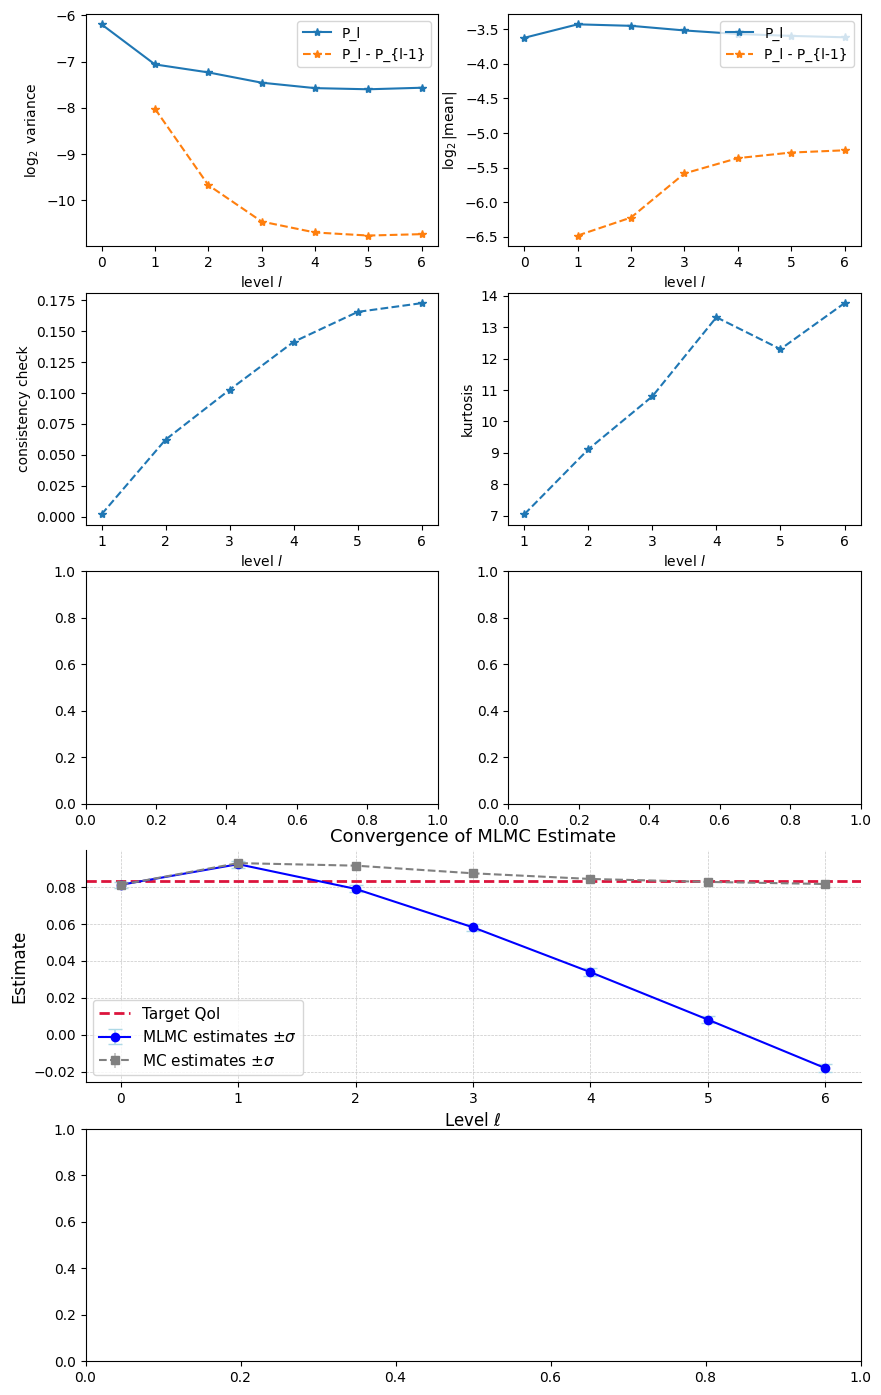

In [6]:
from mlmc.stoch_heat_eqn_qoi import stoch_heat_eqn_qoi
import numpy as np
def default_noise_coupling(dWf):
    
    coupled_noises = (0.5 * dWf[:-2:2, :] +
                      dWf[1:-1:2, :] + 
                      0.5 * dWf[2::2, :])
    coupled_noises *= np.sqrt(1/3)
    return coupled_noises


stoch_heat_eqn_qoi(noise_coupling=default_noise_coupling)